# Experiments

For a full description of the experimental setup, see the [documentation](../docs/experimental-setup.md).

In [1]:
# General setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Prepare a DataFrame to store the results
results = pd.DataFrame(columns=["scenario", "preference_criteria", "objectives", "solver", "utility"])

## Scenario 1: Preference Criteria are Superset of Objectives (SUP)

In this first scenario, we evaluate the maximum utility of the different adaptation techniques, if the objectives do not include all preference criteria in the true preference function.

In [2]:
import experiments.user
import experiments.problem

# Get utility function
SCENARIO_1_PREFERENCE_CRITERIA = ["neck", "shoulder", "torso"]
get_utility = experiments.user.get_utility_function(
    objectives=SCENARIO_1_PREFERENCE_CRITERIA,
    weights=1/3,
)

# Get MOO problem
SCENARIO_1_OBJECTIVES = ["neck", "shoulder"]
problem = experiments.problem.LayoutProblem(
    objectives=SCENARIO_1_OBJECTIVES
)

### Our Solver: U-NSGA-III w/ AASF

Our suggested solver uses the genetic U-NSGA-III algorithm with the AASF decomposition technique.

In [3]:
import experiments.pareto_solver

def get_utilities_of_pareto_optimal_aasf_adaptations(problem, get_utility, verbose = False):
    """Get the utilities of Pareto optimal adaptations."""
    pareto_solver = experiments.pareto_solver.ParetoSolver(problem, pop=100, n_gen=100, seed=42)
    pareto_front_adaptations = pareto_solver.get_adaptations(decomposition="aasf")
    utilities = [get_utility(adaptation) for adaptation in pareto_front_adaptations]
    if verbose:
        print(f"Adaptations (Ours (AASF)): {len(pareto_front_adaptations)} adaptations")
        print("Utilities (Ours (AASF)):", utilities)
        print("Max Utility Adaptation (Ours (AASF)):", pareto_front_adaptations[np.argmax(utilities)])
        print("Max Utility (Ours (AASF)):", np.max(utilities))
    return utilities

utilities_for_aasf_adaptations = get_utilities_of_pareto_optimal_aasf_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "Ours (AASF)",
    "utility": np.max(utilities_for_aasf_adaptations),
}, ignore_index=True)

Adaptations (Ours (AASF)): 3 adaptations
Utilities (Ours (AASF)): [0.8802704924179034, 0.8700231379722703, 0.8623806963310363]
Max Utility Adaptation (Ours (AASF)): Layout(items=[Element(id='0', position=Position(x=9.807642394722166, y=5.985315961888588, z=14.102508315311496), rotation=Rotation(x=0.6355263109978029, y=0.6198955512599637, z=0.22815703064650844, w=0.3841591902832825))])
Max Utility (Ours (AASF)): 0.8802704924179034


We can also generate the entire Pareto frontier.

In [4]:
import experiments.pareto_solver

def get_utilities_of_pareto_optimal_adaptations(problem, get_utility, verbose = False):
    """Get the utilities of Pareto optimal adaptations."""
    pareto_solver = experiments.pareto_solver.ParetoSolver(problem, pop=100, n_gen=100, seed=42)
    pareto_front_adaptations = pareto_solver.get_adaptations()
    utilities = [get_utility(adaptation) for adaptation in pareto_front_adaptations]
    if verbose:
        print(f"Adaptations (Ours (PF)): {len(pareto_front_adaptations)} adaptations")
        print("Utilities (Ours (PF)):", utilities)
        print("Max Utility Adaptation (Ours (PF)):", pareto_front_adaptations[np.argmax(utilities)])
        print("Max Utility (Ours (PF)):", np.max(utilities))
    return utilities

utilities_for_pareto_front_adaptations = get_utilities_of_pareto_optimal_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "Ours (PF)",
    "utility": np.max(utilities_for_pareto_front_adaptations),
}, ignore_index=True)

Adaptations (Ours (PF)): 5 adaptations
Utilities (Ours (PF)): [0.8700231379722703, 0.8802704924179034, 0.8461635646145993, 0.8910355494073863, 0.8623806963310363]
Max Utility Adaptation (Ours (PF)): Layout(items=[Element(id='0', position=Position(x=-15.606332210073283, y=-13.628113330232878, z=-19.79615045376869), rotation=Rotation(x=0.43683948624245916, y=0.026316407425051758, z=0.12167580261783005, w=0.03575771701421536))])
Max Utility (Ours (PF)): 0.8910355494073863


### Baseline Solver 1: Static Weighted Sum (WS)

The first baseline solver is a static weighted sum with equal weights.

In [5]:
import experiments.weighted_sum_solver

def get_utility_of_equally_weighted_sum_adaptation(problem, get_utility, verbose = False):
    """Get the utility of the equally weighted sum adaptation."""
    equally_weighted_sum_solver = experiments.weighted_sum_solver.WeightedSumSolver(problem, weights=1/problem.n_obj, seed=42)
    equally_weighted_sum_adaptation = equally_weighted_sum_solver.get_adaptations()[0]
    equally_weighted_sum_utility = get_utility(equally_weighted_sum_adaptation)
    if verbose:
        print("Equally Weighted Sum Adaptation:", equally_weighted_sum_adaptation)
        print("Equally Weighted Sum Utility:", equally_weighted_sum_utility)
    return equally_weighted_sum_utility

equally_weighted_sum_utility = get_utility_of_equally_weighted_sum_adaptation(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "WS",
    "utility": equally_weighted_sum_utility,
}, ignore_index=True)

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=2.360711458713962, y=-19.79942493019234, z=-4.159182935835284), rotation=Rotation(x=0.1789992668156376, y=0.8194682865399235, z=0.362520192557711, w=0.012605916234388281))])
Equally Weighted Sum Utility: 0.8461635646145993


### Baseline Solver 2: Multiple Single-Objective Solvers (MSO)

The second baseline solver is a single-objective solver that is used for all objectives in the utility function.

In [6]:
import experiments.single_objectives_solver

def get_utilities_of_single_objective_adaptations(problem, get_utility, verbose = False):
    """Get the utilities of Pareto optimal adaptations."""
    single_objectives_solver = experiments.single_objectives_solver.SingleObjectivesSolver(problem, pop=100, n_gen=100, seed=42)
    single_objective_adaptations = single_objectives_solver.get_adaptations()
    utilities = [get_utility(adaptation) for adaptation in single_objective_adaptations]
    if verbose:
        print(f"Adaptations (MSO): {len(single_objective_adaptations)} adaptations")
        print("Utilities (MSO):", utilities)
        print("Max Utility Adaptation (MSO):", single_objective_adaptations[np.argmax(utilities)])
        print("Max Utility (MSO):", np.max(utilities))
    return utilities

utilities_for_mso_adaptations = get_utilities_of_single_objective_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "MSO",
    "utility": np.max(utilities_for_mso_adaptations),
}, ignore_index=True)

Adaptations (MSO): 2 adaptations
Utilities (MSO): [0.8623806963310363, 0.8700231379722703]
Max Utility Adaptation (MSO): Layout(items=[Element(id='0', position=Position(x=-9.477930874322805, y=7.881054982152608, z=14.203510182051893), rotation=Rotation(x=0.03033422473386293, y=0.7783898701428106, z=0.04600264202175275, w=0.37517342090806194))])
Max Utility (MSO): 0.8700231379722703


### Baseline Solver 3: Random Solver (RND)

The third baseline solver is a random solver that returns a random adaptation.

In [7]:
import experiments.random_solver

def get_utility_of_random_adaptation(problem, get_utility, verbose = False):
    """Get the utility of a random adaptation."""
    random_solver = experiments.random_solver.RandomSolver(problem=problem, seed=42)
    random_adaptation = random_solver.get_adaptations(n_adaptations=1)[0]
    utility = get_utility(random_adaptation)
    if verbose:
        print("Adaptation (RND):", random_adaptation)
        print("Utility (RND):", utility)
    return utility

utility_for_random_adaptation = get_utility_of_random_adaptation(problem, get_utility, verbose=True)

Adaptation (RND): Layout(items=[Element(id='0', position=Position(x=10.958241942238534, y=-2.4448624099179064, z=14.343916796455296), rotation=Rotation(x=0.6973680290593639, y=0.09417734788764953, z=0.9756223516367559, w=0.761139701990353))])
Utility (RND): 0.9106866996687881


We can also run the random solver a few times and calculate the average utility of the returned solutions.

In [8]:
def get_expected_utility_of_random_adaptation(problem, get_utility, n_trials = 100, verbose = False):
    """Get the expected utility of a random adaptation."""
    random_solver = experiments.random_solver.RandomSolver(problem=problem, seed=42)
    random_adaptations = random_solver.get_adaptations(n_adaptations=n_trials)
    utilities = [get_utility(random_adaptation) for random_adaptation in random_adaptations]
    if verbose:
        print("Expected Utility (RND):", np.average(utilities))
    return np.average(utilities)

expected_utility_for_random_adaptation = get_expected_utility_of_random_adaptation(problem, get_utility, n_trials=100, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "RND",
    "utility": expected_utility_for_random_adaptation,
}, ignore_index=True)


Expected Utility (RND): 0.8697459788567925


### Results

The results of the experiments are shown in the following table.

In [9]:
# Show results
results[results["scenario"] == "SUP"].sort_values(by="utility", ascending=False)

,scenario,preference_criteria,objectives,solver,utility
1,SUP,"neck, shoulder, torso","neck, shoulder",Ours (PF),0.891036
0,SUP,"neck, shoulder, torso","neck, shoulder",Ours (AASF),0.880270
3,SUP,"neck, shoulder, torso","neck, shoulder",MSO,0.870023
4,SUP,"neck, shoulder, torso","neck, shoulder",RND,0.869746
2,SUP,"neck, shoulder, torso","neck, shoulder",WS,0.846164


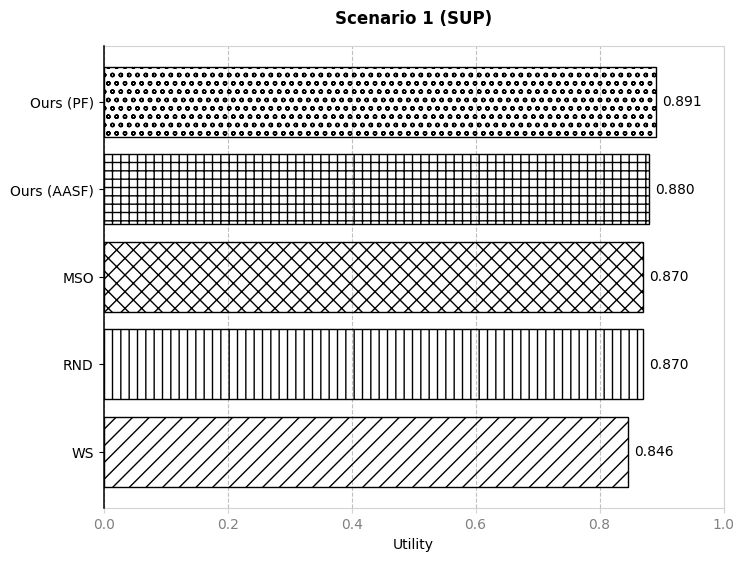

In [10]:
# Visualize results for scenario 1 in a horizontal bar chart
def visualize_results(data, title):
    """Visualize the results for scenario 1."""
    # Get figure
    fig, ax = plt.subplots(figsize=(8, 6))
    # Set title
    ax.set_title(title, fontweight="bold", pad=16)
    # Set x-axis
    ax.set_xlabel("Utility")
    # Set y-axis
    # ax.set_ylabel("Solver")
    # Set grid
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed', axis="x", alpha=0.5)
    # Set limits
    ax.set_xlim(0, 1)
    # Set spines to grey
    ax.spines["bottom"].set_color('lightgray')
    ax.spines["top"].set_color('lightgray')
    ax.spines["right"].set_color('lightgray')
    ax.spines["left"].set_color('k')
    # Set the left spine to be thick
    ax.spines["left"].set_linewidth(1.1)
    ax.spines["left"].set_zorder(10)
    # Set the tick labels and axis labels color to grey
    ax.tick_params(axis="x", which="both", labelcolor='gray', color='lightgray')
    # Plot bars
    hatches = ["//", "||", "xx", "++", "oo", "**"]
    ax.barh(data["solver"], data["utility"],
        edgecolor="k",
        color="none",
        hatch=data["solver"].map(dict(zip(data["solver"].unique(), hatches))),
    )
    # Set y-axis
    ax.set_yticks(data["solver"])
    # Set y-tick labels and make label bold for only solver "Ours"
    ax.set_yticklabels(data["solver"])
    # Set labels
    for i, (solver, utility) in enumerate(zip(data["solver"], data["utility"])):
        ax.text(utility + 0.01, i, f"{utility:.3f}", ha="left", va="center", color="k")
    # Return figure
    return fig

def visualize_scenario_1(results):
    """Visualize the results for scenario 1."""
    # Get data
    data = results[results["scenario"] == "SUP"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results(data, "Scenario 1 (SUP)")
    # Return figure
    return fig

fig_scenario_1 = visualize_scenario_1(results)
plt.show(fig_scenario_1)


## Scenario 2: Preference Criteria are Subset of Objectives (SUB)

In this second scenario, we evaluate the maximum utility of the different adaptation techniques, if the objectives include all preference criteria in the true preference function as well as one additional objective.

In [11]:
# Get utility function
SCENARIO_2_PREFERENCE_CRITERIA = ["neck", "shoulder"]
get_utility = experiments.user.get_utility_function(
    objectives=SCENARIO_2_PREFERENCE_CRITERIA,
    weights=1/2,
)

# Get MOO problem
SCENARIO_2_OBJECTIVES = ["neck", "shoulder", "torso"]
problem = experiments.problem.LayoutProblem(
    objectives=SCENARIO_2_OBJECTIVES
)

### Our Solver: U-NSGA-III w/ AASF

In [12]:
utilities_for_aasf_adaptations = get_utilities_of_pareto_optimal_aasf_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUB",
    "preference_criteria": ", ".join(SCENARIO_2_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_2_OBJECTIVES),
    "solver": "Ours (AASF)",
    "utility": np.max(utilities_for_aasf_adaptations),
}, ignore_index=True)

Adaptations (Ours (AASF)): 1 adaptations
Utilities (Ours (AASF)): [0.7725469797469134]
Max Utility Adaptation (Ours (AASF)): Layout(items=[Element(id='0', position=Position(x=19.988297667146735, y=19.783567434885374, z=17.497338125282923), rotation=Rotation(x=0.9987483953883072, y=0.989761908729914, z=0.9817070957777828, w=0.8914618625781563))])
Max Utility (Ours (AASF)): 0.7725469797469134


In [13]:
utilities_for_pareto_front_adaptations = get_utilities_of_pareto_optimal_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUB",
    "preference_criteria": ", ".join(SCENARIO_2_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_2_OBJECTIVES),
    "solver": "Ours (PF)",
    "utility": np.max(utilities_for_pareto_front_adaptations),
}, ignore_index=True)

Adaptations (Ours (PF)): 1 adaptations
Utilities (Ours (PF)): [0.7725469797469134]
Max Utility Adaptation (Ours (PF)): Layout(items=[Element(id='0', position=Position(x=19.988297667146735, y=19.783567434885374, z=17.497338125282923), rotation=Rotation(x=0.9987483953883072, y=0.989761908729914, z=0.9817070957777828, w=0.8914618625781563))])
Max Utility (Ours (PF)): 0.7725469797469134


### Baseline Solver 1: Static Weighted Sum (WS)

In [14]:
equally_weighted_sum_utility = get_utility_of_equally_weighted_sum_adaptation(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUB",
    "preference_criteria": ", ".join(SCENARIO_2_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_2_OBJECTIVES),
    "solver": "WS",
    "utility": equally_weighted_sum_utility,
}, ignore_index=True)

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=19.988297667146735, y=19.783567434885374, z=17.497338125282923), rotation=Rotation(x=0.9987483953883072, y=0.989761908729914, z=0.9817070957777828, w=0.8914618625781563))])
Equally Weighted Sum Utility: 0.7725469797469134


### Baseline Solver 2: Multiple Single-Objective Solvers (MSO)

In [15]:
utilities_for_mso_adaptations = get_utilities_of_single_objective_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUB",
    "preference_criteria": ", ".join(SCENARIO_2_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_2_OBJECTIVES),
    "solver": "MSO",
    "utility": np.max(utilities_for_mso_adaptations),
}, ignore_index=True)

Adaptations (MSO): 3 adaptations
Utilities (MSO): [0.7725469797469134, 0.7725469797469134, 0.7725469797469134]
Max Utility Adaptation (MSO): Layout(items=[Element(id='0', position=Position(x=19.988297667146735, y=19.783567434885374, z=17.497338125282923), rotation=Rotation(x=0.9987483953883072, y=0.989761908729914, z=0.9817070957777828, w=0.8914618625781563))])
Max Utility (MSO): 0.7725469797469134


### Baseline Solver 3: Random Solver (RND)

In [16]:
expected_utility_for_random_adaptation = get_expected_utility_of_random_adaptation(problem, get_utility, n_trials=100, verbose=True)
results = results.append({
    "scenario": "SUB",
    "preference_criteria": ", ".join(SCENARIO_2_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_2_OBJECTIVES),
    "solver": "RND",
    "utility": expected_utility_for_random_adaptation,
}, ignore_index=True)

Expected Utility (RND): 0.8262979052080666


### Results

In [17]:
# Show results
results[results["scenario"] == "SUB"].sort_values(by="utility", ascending=False)

,scenario,preference_criteria,objectives,solver,utility
9,SUB,"neck, shoulder","neck, shoulder, torso",RND,0.826298
5,SUB,"neck, shoulder","neck, shoulder, torso",Ours (AASF),0.772547
6,SUB,"neck, shoulder","neck, shoulder, torso",Ours (PF),0.772547
7,SUB,"neck, shoulder","neck, shoulder, torso",WS,0.772547
8,SUB,"neck, shoulder","neck, shoulder, torso",MSO,0.772547


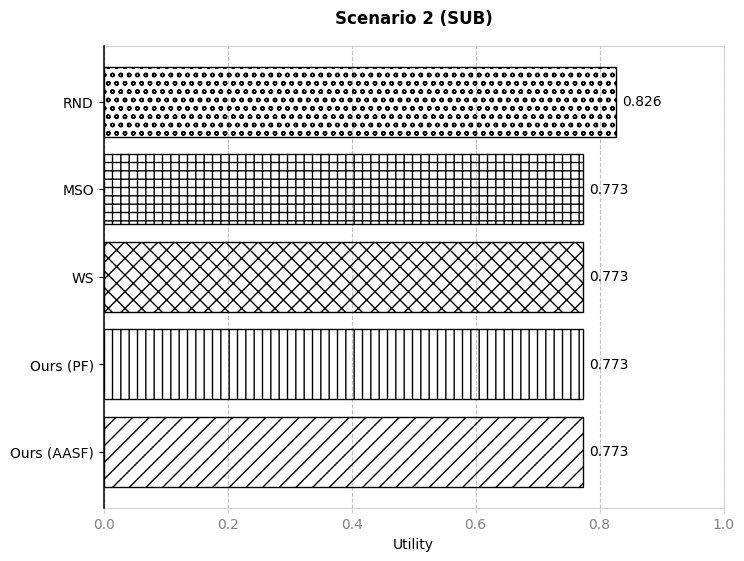

In [18]:
def visualize_scenario_2(results):
    """Visualize the results for scenario 2."""
    # Get data
    data = results[results["scenario"] == "SUB"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results(data, "Scenario 2 (SUB)")
    # Return figure
    return fig

fig_scenario_2 = visualize_scenario_2(results)
plt.show(fig_scenario_2)

## Scenario 3: Preference Criteria are Disjoint from Objectives (DIS)

In this third scenario, we evaluate the maximum utility of the different adaptation techniques, if the objectives do not include any preference criteria in the true preference function.

In [19]:
# Get utility function
SCENARIO_3_PREFERENCE_CRITERIA = ["neck", "shoulder"]
get_utility = experiments.user.get_utility_function(
    objectives=SCENARIO_3_PREFERENCE_CRITERIA,
    weights=1/2,
)

# Get MOO problem
SCENARIO_3_OBJECTIVES = ["torso", "reach"]
problem = experiments.problem.LayoutProblem(
    objectives=SCENARIO_3_OBJECTIVES
)

### Our Solver: U-NSGA-III w/ AASF

In [20]:
utilities_for_aasf_adaptations = get_utilities_of_pareto_optimal_aasf_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "DIS",
    "preference_criteria": ", ".join(SCENARIO_3_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_3_OBJECTIVES),
    "solver": "Ours (AASF)",
    "utility": np.max(utilities_for_aasf_adaptations),
}, ignore_index=True)

Adaptations (Ours (AASF)): 1 adaptations
Utilities (Ours (AASF)): [0.8735215646219225]
Max Utility Adaptation (Ours (AASF)): Layout(items=[Element(id='0', position=Position(x=-13.07032235496906, y=-6.080727372859721, z=-3.580940077300073), rotation=Rotation(x=0.14141328998338792, y=0.8087144254913442, z=0.6918558189961137, w=0.8680179678464244))])
Max Utility (Ours (AASF)): 0.8735215646219225


In [21]:
utilities_for_pareto_front_adaptations = get_utilities_of_pareto_optimal_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "DIS",
    "preference_criteria": ", ".join(SCENARIO_3_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_3_OBJECTIVES),
    "solver": "Ours (PF)",
    "utility": np.max(utilities_for_pareto_front_adaptations),
}, ignore_index=True)

Adaptations (Ours (PF)): 1 adaptations
Utilities (Ours (PF)): [0.8735215646219225]
Max Utility Adaptation (Ours (PF)): Layout(items=[Element(id='0', position=Position(x=-13.07032235496906, y=-6.080727372859721, z=-3.580940077300073), rotation=Rotation(x=0.14141328998338792, y=0.8087144254913442, z=0.6918558189961137, w=0.8680179678464244))])
Max Utility (Ours (PF)): 0.8735215646219225


### Baseline Solver 1: Static Weighted Sum (WS)

In [22]:
equally_weighted_sum_utility = get_utility_of_equally_weighted_sum_adaptation(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "DIS",
    "preference_criteria": ", ".join(SCENARIO_3_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_3_OBJECTIVES),
    "solver": "WS",
    "utility": equally_weighted_sum_utility,
}, ignore_index=True)

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=-13.07032235496906, y=-6.080727372859721, z=-3.580940077300073), rotation=Rotation(x=0.14141328998338792, y=0.8087144254913442, z=0.6918558189961137, w=0.8680179678464244))])
Equally Weighted Sum Utility: 0.8735215646219225


### Baseline Solver 2: Multiple Single-Objective Solvers (MSO)

In [23]:
utilities_for_mso_adaptations = get_utilities_of_single_objective_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "DIS",
    "preference_criteria": ", ".join(SCENARIO_3_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_3_OBJECTIVES),
    "solver": "MSO",
    "utility": np.max(utilities_for_mso_adaptations),
}, ignore_index=True)

Adaptations (MSO): 2 adaptations
Utilities (MSO): [0.8735215646219225, 0.8735215646219225]
Max Utility Adaptation (MSO): Layout(items=[Element(id='0', position=Position(x=-13.07032235496906, y=-6.080727372859721, z=-3.580940077300073), rotation=Rotation(x=0.14141328998338792, y=0.8087144254913442, z=0.6918558189961137, w=0.8680179678464244))])
Max Utility (MSO): 0.8735215646219225


### Baseline Solver 3: Random Solver (RND)

In [24]:
expected_utility_for_random_adaptation = get_expected_utility_of_random_adaptation(problem, get_utility, n_trials=100, verbose=True)
results = results.append({
    "scenario": "DIS",
    "preference_criteria": ", ".join(SCENARIO_3_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_3_OBJECTIVES),
    "solver": "RND",
    "utility": expected_utility_for_random_adaptation,
}, ignore_index=True)

Expected Utility (RND): 0.8262979052080666


### Results

In [25]:
# Show results
results[results["scenario"] == "DIS"].sort_values(by="utility", ascending=False)

,scenario,preference_criteria,objectives,solver,utility
10,DIS,"neck, shoulder","torso, reach",Ours (AASF),0.873522
11,DIS,"neck, shoulder","torso, reach",Ours (PF),0.873522
12,DIS,"neck, shoulder","torso, reach",WS,0.873522
13,DIS,"neck, shoulder","torso, reach",MSO,0.873522
14,DIS,"neck, shoulder","torso, reach",RND,0.826298


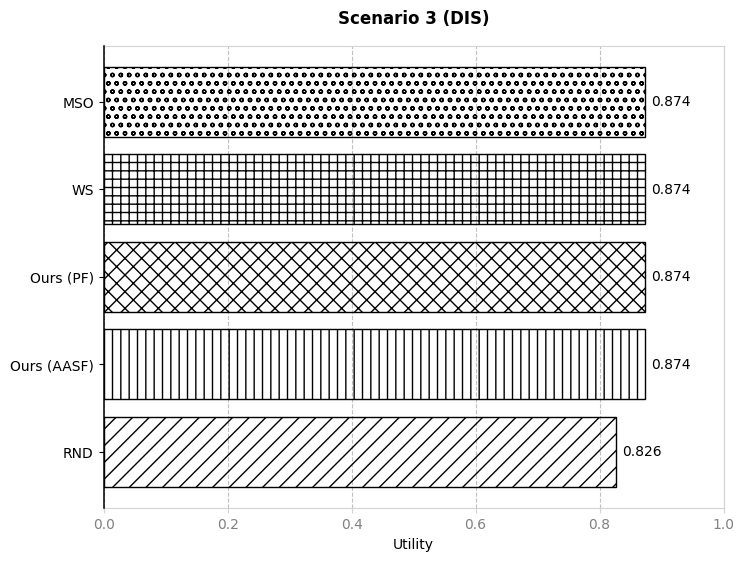

In [26]:
def visualize_scenario_3(results):
    """Visualize the results for scenario 3."""
    # Get data
    data = results[results["scenario"] == "DIS"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results(data, "Scenario 3 (DIS)")
    # Return figure
    return fig

fig_scenario_3 = visualize_scenario_3(results)
plt.show(fig_scenario_3)

## Scenario 4: Preference Criteria are Equal to Objectives (EQU)

In this fourth scenario, we evaluate the maximum utility of the different adaptation techniques, if the objectives are equal to the preference criteria in the true preference function.

In [27]:
# Get utility function
SCENARIO_4_PREFERENCE_CRITERIA = ["neck", "shoulder"]
get_utility = experiments.user.get_utility_function(
    objectives=SCENARIO_4_PREFERENCE_CRITERIA,
    weights=1/2,
)

# Get MOO problem
SCENARIO_4_OBJECTIVES = SCENARIO_4_PREFERENCE_CRITERIA
problem = experiments.problem.LayoutProblem(
    objectives=SCENARIO_4_OBJECTIVES
)

### Our Solver: U-NSGA-III w/ AASF

In [28]:
utilities_for_aasf_adaptations = get_utilities_of_pareto_optimal_aasf_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "EQU",
    "preference_criteria": ", ".join(SCENARIO_4_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_4_OBJECTIVES),
    "solver": "Ours (AASF)",
    "utility": np.max(utilities_for_aasf_adaptations),
}, ignore_index=True)

Adaptations (Ours (AASF)): 3 adaptations
Utilities (Ours (AASF)): [0.8204057386268551, 0.8050347069584053, 0.874409927826035]
Max Utility Adaptation (Ours (AASF)): Layout(items=[Element(id='0', position=Position(x=2.9663322755596555, y=-18.01154136404964, z=10.313844418574764), rotation=Rotation(x=0.003475514504371763, y=0.13566018614764658, z=0.23471457278123978, w=0.7570932606281165))])
Max Utility (Ours (AASF)): 0.874409927826035


In [29]:
utilities_for_pareto_front_adaptations = get_utilities_of_pareto_optimal_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "EQU",
    "preference_criteria": ", ".join(SCENARIO_4_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_4_OBJECTIVES),
    "solver": "Ours (PF)",
    "utility": np.max(utilities_for_pareto_front_adaptations),
}, ignore_index=True)

Adaptations (Ours (PF)): 5 adaptations
Utilities (Ours (PF)): [0.8050347069584053, 0.8204057386268551, 0.8747208162787068, 0.8742635008058796, 0.874409927826035]
Max Utility Adaptation (Ours (PF)): Layout(items=[Element(id='0', position=Position(x=2.360711458713962, y=-19.79942493019234, z=-4.159182935835284), rotation=Rotation(x=0.1789992668156376, y=0.8194682865399235, z=0.362520192557711, w=0.012605916234388281))])
Max Utility (Ours (PF)): 0.8747208162787068


### Baseline Solver 1: Static Weighted Sum (WS)

In [30]:
equally_weighted_sum_utility = get_utility_of_equally_weighted_sum_adaptation(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "EQU",
    "preference_criteria": ", ".join(SCENARIO_4_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_4_OBJECTIVES),
    "solver": "WS",
    "utility": equally_weighted_sum_utility,
}, ignore_index=True)

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=2.360711458713962, y=-19.79942493019234, z=-4.159182935835284), rotation=Rotation(x=0.1789992668156376, y=0.8194682865399235, z=0.362520192557711, w=0.012605916234388281))])
Equally Weighted Sum Utility: 0.8747208162787068


### Baseline Solver 2: Multiple Single-Objective Solvers (MSO)

In [31]:
utilities_for_mso_adaptations = get_utilities_of_single_objective_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "EQU",
    "preference_criteria": ", ".join(SCENARIO_4_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_4_OBJECTIVES),
    "solver": "MSO",
    "utility": np.max(utilities_for_mso_adaptations),
}, ignore_index=True)

Adaptations (MSO): 2 adaptations
Utilities (MSO): [0.874409927826035, 0.8050347069584053]
Max Utility Adaptation (MSO): Layout(items=[Element(id='0', position=Position(x=2.9663322755596555, y=-18.01154136404964, z=10.313844418574764), rotation=Rotation(x=0.003475514504371763, y=0.13566018614764658, z=0.23471457278123978, w=0.7570932606281165))])
Max Utility (MSO): 0.874409927826035


### Baseline Solver 3: Random Solver (RND)

In [32]:
expected_utility_for_random_adaptation = get_expected_utility_of_random_adaptation(problem, get_utility, n_trials=100, verbose=True)
results = results.append({
    "scenario": "EQU",
    "preference_criteria": ", ".join(SCENARIO_4_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_4_OBJECTIVES),
    "solver": "RND",
    "utility": expected_utility_for_random_adaptation,
}, ignore_index=True)

Expected Utility (RND): 0.8262979052080666


### Results

In [33]:
# Show results
results[results["scenario"] == "EQU"].sort_values(by="utility", ascending=False)

,scenario,preference_criteria,objectives,solver,utility
16,EQU,"neck, shoulder","neck, shoulder",Ours (PF),0.874721
17,EQU,"neck, shoulder","neck, shoulder",WS,0.874721
15,EQU,"neck, shoulder","neck, shoulder",Ours (AASF),0.874410
18,EQU,"neck, shoulder","neck, shoulder",MSO,0.874410
19,EQU,"neck, shoulder","neck, shoulder",RND,0.826298


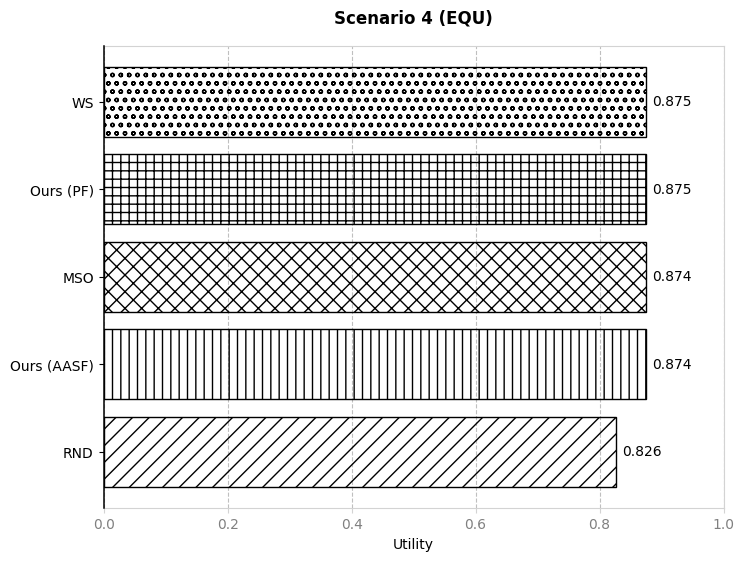

In [34]:
def visualize_scenario_4(results):
    """Visualize the results for scenario 4."""
    # Get data
    data = results[results["scenario"] == "EQU"].sort_values(by="utility", ascending=True)
    # Get figure
    fig = visualize_results(data, "Scenario 4 (EQU)")
    # Return figure
    return fig

fig_scenario_4 = visualize_scenario_4(results)
plt.show(fig_scenario_4)